In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
RANDOM_STATE = 17

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [4]:
train_len = train.shape[0]

In [5]:
df = pd.concat([train, test], axis=0)

In [6]:
df['country'].value_counts()

country
Argentina    32865
Canada       32865
Estonia      32865
Japan        32865
Spain        32865
Name: count, dtype: int64

In [7]:
df['store'].value_counts()

store
Kaggle Learn    54775
Kaggle Store    54775
Kagglazon       54775
Name: count, dtype: int64

In [8]:
df['product'].value_counts()

product
Using LLMs to Improve Your Coding                 32865
Using LLMs to Train More LLMs                     32865
Using LLMs to Win Friends and Influence People    32865
Using LLMs to Win More Kaggle Competitions        32865
Using LLMs to Write Better                        32865
Name: count, dtype: int64

In [9]:
df.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0


In [10]:
def datetime(df):
    df['date'] = pd.to_datetime(df["date"])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week
    df['quarter'] = df['date'].dt.quarter
    return df

In [11]:
df = datetime(df)

In [12]:
df['date'] = df.date.dt.to_period('D')

In [13]:
df.head()

,id,date,country,store,product,num_sold,year,month,day,day_of_week,quarter
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63.0,2017,1,1,6,1
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66.0,2017,1,1,6,1
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9.0,2017,1,1,6,1
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59.0,2017,1,1,6,1
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49.0,2017,1,1,6,1


In [14]:
df['is_weekend'] = df['day_of_week'].isin([5,6])*1

In [15]:
le = LabelEncoder()
df['product'] = le.fit_transform(df['product'])
df['store'] = le.fit_transform(df['store'])
df['country'] = le.fit_transform(df['country'])

In [16]:
average_sold = df[:train_len].groupby('date')['num_sold'].mean()
trend = average_sold.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

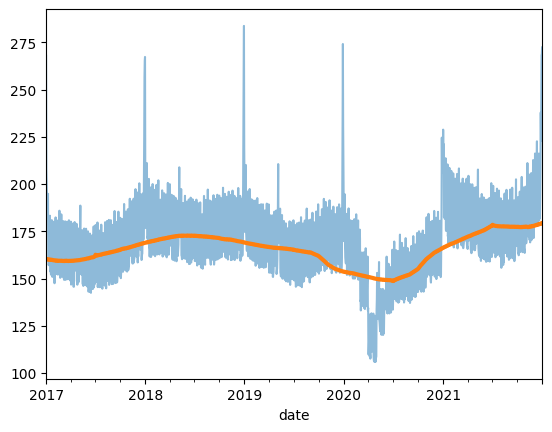

In [17]:
ax = average_sold.plot(alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [18]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [19]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


/tmp/ipykernel_15298/1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


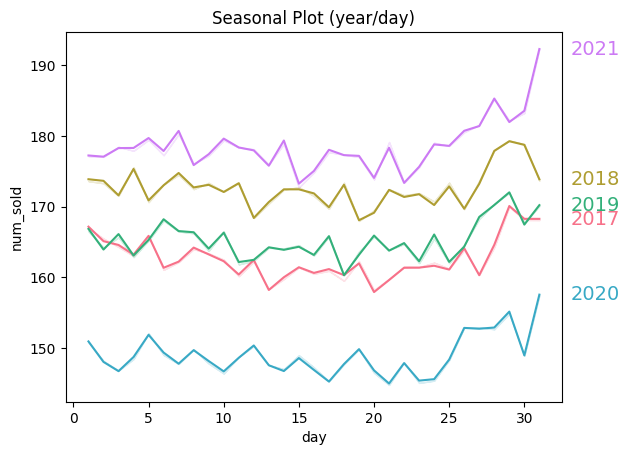

In [20]:
seasonal_plot(df[:train_len], y="num_sold", period="year", freq="day");

In [93]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None # store column names from fit method
    def fit(self, X_1, X_2, y):
        y_fit = pd.DataFrame(
            self.model_1.fit(X_1, y).predict(X_1),
            X_1.index, y.columns
        )
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze() # wide to long

        self.model_2.fit(X_2, y_resid)
        self.y_columns = y.columns
        self.y_fit = y_fit
        self.y_resid = y_resid

    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            # YOUR CODE HERE: predict with self.model_1
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()  # wide to long

        # YOUR CODE HERE: add self.model_2 predictions to y_pred
        y_pred += self.model_2.predict(X_2)
    
        return y_pred.unstack()  # long to wide

In [73]:
model = BoostedHybrid(model_1=LinearRegression(), model_2=XGBRegressor())

In [83]:
y = df[:train_len][['date','num_sold']]
y = y.set_index('date')
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()
X_2 = df[:train_len].drop(['num_sold'], axis=1)
X_2 = X_2.set_index('date')
X_2 = X_2.drop(['id'], axis=1)

In [94]:
model.fit(X_1, X_2, y)

AttributeError: 'DataFrame' object has no attribute 'name'